In [1]:
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import BertTokenizer, BertConfig, Trainer
from transformers import EvalPrediction
from transformers import TrainingArguments

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_curve 
import pandas as pd
import numpy as np
import json
import re
import tqdm

In [2]:
from model import EnsembleSequenceRegressor
from explain import EnsembleExplainer

**Load tokenizers and submodels**

In [3]:
#model_name = "Rostlab/prot_t5_xl_uniref50" # for embedding only
seq_model_name = "Rostlab/prot_bert_bfd" # for fine-tuning

In [4]:
seq_tokenizer = BertTokenizer.from_pretrained(seq_model_name, do_lower_case=False)

In [5]:
tokenizer_directory =  '/home/xvg/maskedevolution/models/bert_large_1B/tokenizer'
smiles_model_name = '/home/xvg/maskedevolution/models/bert_large_1B/model'

In [6]:
tokenizer_config = json.load(open(tokenizer_directory+'/config.json','r'))

In [7]:
#smiles_tokenizer =  RobertaTokenizer.from_pretrained(tokenizer_directory, **tokenizer_config, do_lower_case=False)
smiles_tokenizer =  BertTokenizer.from_pretrained(tokenizer_directory, **tokenizer_config)
smiles_tokenizer.do_lower_case

False

In [8]:
def expand_seqs(seqs):
    input_fixed = ["".join(seq.split()) for seq in seqs]
    input_fixed = [re.sub(r"[UZOB]", "X", seq) for seq in input_fixed]
    return [list(seq) for seq in input_fixed]

In [9]:
# on-the-fly tokenization
from rdkit import Chem
def encode(item):
        seq_encodings = seq_tokenizer(expand_seqs(item['seq'])[0],
                                     is_split_into_words=True,
                                     return_offsets_mapping=False,
                                     truncation=True,
                                     padding='max_length',
                                     add_special_tokens=True,
                                     max_length=max_seq_length)
        
        try:
            # make canonical
            item['smiles'] = [Chem.MolToSmiles(Chem.MolFromSmiles(item['smiles'][0]))]
        except:
            pass
        
        smiles_encodings = smiles_tokenizer(item['smiles'][0],
                                            padding='max_length',
                                            max_length=max_smiles_length,
                                            add_special_tokens=True,
                                            truncation=True)
        item['input_ids'] = [torch.cat([torch.tensor(seq_encodings['input_ids']),
                                        torch.tensor(smiles_encodings['input_ids'])])]
        item['token_type_ids'] = [torch.cat([torch.tensor(seq_encodings['token_type_ids']),
                                        torch.tensor(smiles_encodings['token_type_ids'])])]
        item['attention_mask'] = [torch.cat([torch.tensor(seq_encodings['attention_mask']),
                                            torch.tensor(smiles_encodings['attention_mask'])])]
        return item

In [10]:
class AffinityDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        #affinity = item['neg_log10_affinity_M']
        affinity = item['affinity']
        #affinity = (affinity**lmbda-1)/lmbda # transform
        #item['labels'] = torch.tensor(float(affinity))
        item['labels'] = float(affinity)
        
        # drop the non-encoded input
        item.pop('smiles')
        item.pop('seq')
        item.pop('neg_log10_affinity_M')
        item.pop('affinity')
        return item

    def __len__(self):
        return len(self.dataset)

**Load model**

In [11]:
max_smiles_length = 200
max_seq_length = 4096

In [12]:
def model_init():
    return EnsembleSequenceRegressor(seq_model_name, smiles_model_name, max_seq_length=max_seq_length)

In [13]:
def compute_metrics(p: EvalPrediction):
    preds_list, out_label_list = p.predictions, p.label_ids

    return {
        "mse": mean_squared_error(out_label_list, preds_list),
        "mae": mean_absolute_error(out_label_list, preds_list),
    }

In [14]:
trainer = Trainer(
    model_init=model_init,                # the instantiated 🤗 Transformers model to be trained
    compute_metrics = compute_metrics,    # evaluation metric
    args=TrainingArguments(per_device_eval_batch_size=1,output_dir='results')
)

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/xvg/maskedevolution/models/bert_large_1B/model were not used when initial

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 39.59 GiB total capacity; 813.29 MiB already allocated; 12.19 MiB free; 816.00 MiB reserved in total by PyTorch)

In [ ]:
checkpoint = torch.load('/home/xvg/affinity_pred/train/ensemble_model_4608/pytorch_model.bin')

In [ ]:
# sparse attention may not be enabled 
#trainer.model.load_state_dict(checkpoint,strict=False)
trainer.model.load_state_dict(checkpoint)

**Test dataset**

In [ ]:
data_all = load_dataset("jglaser/binding_affinity",split='train')
split = data_all.train_test_split(train_size=100,test_size=10)
test = split['train']
test.set_transform(encode)

In [18]:
test_dataset = AffinityDataset(test)

In [19]:
y = trainer.predict(test_dataset)

/home/xvg/miniconda3/envs/affinity/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [20]:
y

PredictionOutput(predictions=array([ 0.32124138,  0.3061055 , -0.72764844, -0.6936505 , -0.7254505 ,
       -0.8304226 ,  0.64439046, -0.7418345 ,  0.2963153 ,  1.638511  ,
       -0.7818743 ,  0.9971643 , -1.2902143 ,  0.17101265,  0.7863678 ,
        0.20532002, -0.76875687, -0.34004316, -0.19042172, -0.7504456 ,
        0.5374241 , -1.9025686 , -0.3167193 ,  1.619009  , -0.3985955 ,
        0.5961142 , -0.840366  ,  0.6367586 , -0.03783577,  1.2222584 ,
        0.55545056, -0.37538514,  0.21855524,  1.0563157 , -0.14966153,
        0.3398417 , -1.0340327 , -1.1971635 ,  0.4264646 , -0.18304488,
        0.45446005, -0.55690193,  0.74401474,  2.0746708 , -1.2185326 ,
        0.07104906,  0.02237124, -0.0153105 ,  0.7870215 ,  0.2756476 ,
       -0.13184711, -1.2537429 , -0.79735833,  1.9936289 , -0.93518215,
        0.7910108 ,  0.40115878,  0.6873447 ,  1.010506  , -0.50933325,
        1.2978306 , -0.02317927,  0.11123426, -0.6093826 , -1.1068815 ,
        1.8449064 , -0.5665149 , -0

**Load Postera Mpro dataset**

In [21]:
# un-normalize predictions [to -log_10 affinity[M] units]
mean, var = (6.49685099, 2.43570803)
def scale(x):
    return x*np.sqrt(var)+mean

In [15]:
mpro_seq_5r84 = "SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ"

In [16]:
len(mpro_seq_5r84)

306

In [17]:
class PosteraDataset(Dataset):
    def __init__(self, df, mean, var, seq):
        self.df = df
        self.mean = mean
        self.var = var
        self.seq = seq
        
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        item = {'smiles': [row.SMILES], 'seq': [self.seq]}
        item = encode(item)
        
        # get first (single) item
        item['input_ids'] = item['input_ids'][0]
        item['token_type_ids'] = item['token_type_ids'][0]
        item['attention_mask'] = item['attention_mask'][0]
        
        affinity = 6-np.log(row['f_avg_IC50'])/np.log(10)
        affinity = (affinity-self.mean)/np.sqrt(self.var)
        item['labels'] = float(affinity)
        
        # drop the non-encoded input
        item.pop('smiles')
        item.pop('seq')
        return item

    def __len__(self):
        return len(self.df)

In [18]:
df = pd.read_csv('/home/xvg/activity_data.csv')
df = df[~df['f_avg_IC50'].isnull()].reset_index(drop=True)

In [22]:
postera_dataset = PosteraDataset(df=df, mean=mean, var=var, seq=mpro_seq_5r84)

In [23]:
len(postera_dataset)

1260

In [34]:
postera_dataset[0]

{'input_ids': tensor([ 2, 10,  7,  ...,  0,  0,  0]),
 'token_type_ids': tensor([0, 0, 0,  ..., 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0]),
 'labels': -0.7166440458798271}

**Test on Mpro dataset**

In [92]:
y=trainer.predict(postera_dataset)

/home/xvg/miniconda3/envs/affinity/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [93]:
y

PredictionOutput(predictions=array([-0.18427008, -0.37227243, -0.3434132 , ..., -0.87106794,
       -0.916091  , -1.2610006 ], dtype=float32), label_ids=array([-0.71664405, -1.017186  ,  0.22602691, ..., -1.4737209 ,
       -1.2321837 , -1.4457135 ], dtype=float32), metrics={'test_loss': 0.5210833549499512, 'test_mse': 0.5210091471672058, 'test_mae': 0.6068599224090576, 'test_runtime': 169.6161, 'test_samples_per_second': 7.429, 'init_mem_cpu_alloc_delta': 2788270080, 'init_mem_gpu_alloc_delta': 2384222720, 'init_mem_cpu_peaked_delta': 1997332480, 'init_mem_gpu_peaked_delta': 0, 'test_mem_cpu_alloc_delta': 5605076992, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 147369984, 'test_mem_gpu_peaked_delta': 382540800})

In [94]:
df['prediction'] = scale(y.predictions)

In [95]:
y.predictions

array([-0.18427008, -0.37227243, -0.3434132 , ..., -0.87106794,
       -0.916091  , -1.2610006 ], dtype=float32)

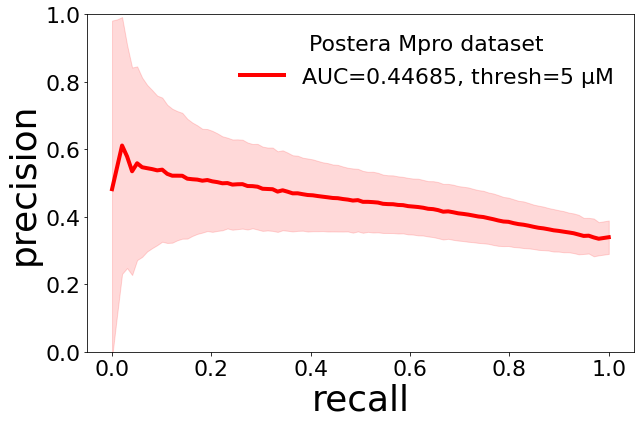

In [125]:
import matplotlib.pyplot as plt

thresh = 5
nbootstrap = 500
samplesize = 100
x = np.linspace(0,1,100)

ps = []
for i in range(nbootstrap):
    df_sample = df.sample(n=samplesize,replace=True)
    yr = df_sample.f_avg_IC50 < thresh
    #yr = df_sample.f_inhibition_at_20_uM > thresh
    p, r, _ = precision_recall_curve(yr, df_sample.prediction)
    ps.append(np.interp(x,r[::-1],p[::-1]))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15
fig, ax = plt.subplots()
fig.set_size_inches(9,6)

ax.plot(x,pavg,label='AUC={:.5f}, thresh={} $\\mathrm{{\\mu M}}$'.format(auc,thresh),color='r',lw=4)
ax.fill_between(x, pavg - perr, pavg + perr, color='r', alpha=alpha_err)


ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=36)
ax.set_ylabel('precision',fontsize=36)
ax.set_ylim(0,1)
ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,title='Postera Mpro dataset',fontsize=22)
l.get_title().set_fontsize(22)

fig.tight_layout()
fig.savefig('affinity_pred.png',dpi=300)

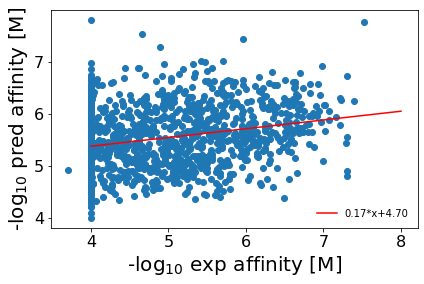

In [126]:
from scipy.stats import linregress

fig, ax = plt.subplots()
x = 6-np.log(df['f_avg_IC50'])/np.log(10)
y = df['prediction'].values
ax.scatter(x,y)
res = linregress(x,y)

xfit = np.linspace(4,8,2)
ax.plot(xfit,res.intercept + res.slope*xfit, 'r', label=f"{res.slope :.2f}*x+{res.intercept:.2f}")
ax.set_ylabel('-log$_{{10}}$ pred affinity [M]',fontsize=20)
ax.set_xlabel('-log$_{{10}}$ exp affinity [M]',fontsize=20)
ax.legend(frameon=False)
ax.tick_params(labelsize=16)
fig.tight_layout()
fig.savefig('scatter.png')

In [101]:
df['prediction'].hist(bins=50)

<AxesSubplot:xlabel='-log$_{{10}}$ exp affinity [M]', ylabel='-log$_{{10}}$ pred affinity [M]'>

In [103]:
mpro_seq_5r84

'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ'

In [104]:
df.iloc[0].SMILES

'COc1ccc2cncc(NC(=O)[C@@]3(OC)CCOc4ccc(Cl)cc43)c2c1'

In [105]:
df.to_csv('data/affinity_with_pred.csv')

In [124]:
df = pd.read_csv('data/affinity_with_pred.csv')

In [127]:
a = 6-np.log(df.sort_values(by='f_avg_IC50',ascending=True)['f_avg_IC50'].head(20))/np.log(10)

In [128]:
a

864     7.522005
420     7.392016
1072    7.301030
216     7.301030
217     7.301030
400     7.301030
74      7.287718
75      7.222863
60      7.218678
200     7.213451
80      7.159270
51      7.075906
689     7.075906
197     7.014198
52      7.014198
205     7.010150
859     6.998756
758     6.980247
101     6.970423
710     6.950993
Name: f_avg_IC50, dtype: float64

In [129]:
b = df.sort_values(by='prediction',ascending=False)['prediction'].head(20)

In [130]:
b

927     7.803374
864     7.772982
999     7.537548
1041    7.437103
921     7.283037
562     7.027723
960     7.013390
441     7.003138
847     6.981729
1025    6.955812
455     6.952915
758     6.928366
887     6.892138
315     6.889587
932     6.882111
757     6.880176
401     6.870552
7       6.861620
247     6.832571
63      6.808632
Name: prediction, dtype: float64

In [131]:
np.intersect1d(a.index,b.index)

array([758, 864])

**Load NCATS Mpro dataset**

In [24]:
mpro_seq_5r84 = "SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ"

In [25]:
len(mpro_seq_5r84)

306

In [26]:
class NCATSDataset(Dataset):
    def __init__(self, df, mean, var, seq):
        self.df = df
        self.mean = mean
        self.var = var
        self.seq = seq
        
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        item = {'smiles': [row.SMILES], 'seq': [self.seq]}
        item = encode(item)
        
        # get first (single) item
        item['input_ids'] = item['input_ids'][0]
        item['token_type_ids'] = item['token_type_ids'][0]
        item['attention_mask'] = item['attention_mask'][0]
        
        affinity = -row['LOG_AC50']
        affinity = (affinity-self.mean)/np.sqrt(self.var)
        item['labels'] = float(affinity)
        
        # drop the non-encoded input
        item.pop('smiles')
        item.pop('seq')
        return item

    def __len__(self):
        return len(self.df)

In [27]:
df_ncats = pd.read_csv('data/3CL_enzymatic_activity.tsv',sep='\t')
df_ncats = df_ncats[df_ncats['LOG_AC50'].notnull()].reset_index()

In [28]:
df_ncats['LOG_AC50'].dropna()

0     -4.55
1     -5.20
2     -6.20
3     -5.40
4     -4.50
       ... 
447   -5.05
448   -5.50
449   -5.05
450   -4.80
451   -4.45
Name: LOG_AC50, Length: 452, dtype: float64

In [29]:
len(df_ncats[df_ncats['LOG_AC50'].notnull()])

452

In [30]:
ncats_dataset = NCATSDataset(df=df_ncats, mean=mean, var=var, seq=mpro_seq_5r84)

In [31]:
ncats_dataset[0]

{'input_ids': tensor([ 2, 10,  7,  ...,  0,  0,  0]),
 'token_type_ids': tensor([0, 0, 0,  ..., 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0]),
 'labels': -1.2474412422857442}

In [32]:
y=trainer.predict(ncats_dataset)

NameError: name 'trainer' is not defined

In [146]:
df_ncats['prediction'] = scale(y.predictions)

In [147]:
len(df_ncats)

452

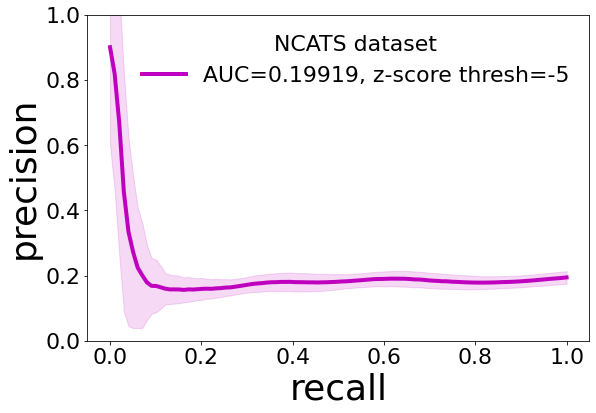

In [148]:
import matplotlib.pyplot as plt

thresh = -5
nbootstrap = 200
samplesize = 500
x = np.linspace(0,1,100)

ps = []
for i in range(nbootstrap):
    df_sample = df_ncats.sample(n=samplesize,replace=True)
    yr = df_sample['LOG_AC50'] < thresh
    p, r, _ = precision_recall_curve(yr, df_sample['prediction'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15
fig, ax = plt.subplots()
fig.set_size_inches(9,6)

ax.plot(x,pavg,label='AUC={:.5f}, z-score thresh={}'.format(auc,thresh),color='m',lw=4)
ax.fill_between(x, pavg - perr, pavg + perr, color='m', alpha=alpha_err)

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=36)
ax.set_ylabel('precision',fontsize=36)
ax.set_ylim(0,1)
ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,title='NCATS dataset',fontsize=22)
l.get_title().set_fontsize(22)

fig.savefig('affinity_pred_ncats.png',dpi=300)

**Hit expansion**

In [149]:
df_exp = pd.read_csv('/home/xvg/exp_merge.csv')
df_exp['% residual activity'] = df_exp['% residual activity'].str.split('%').str[0].astype('float32')
df_exp = df_exp[df_exp['SMILES_fp'].notnull() | df_exp['SMILES_map4'].notnull()].reset_index()

In [150]:
from rdkit import Chem

In [151]:
class HitExpansionDataset(Dataset):
    def __init__(self, df, seq):
        self.df = df
        self.seq = seq
        
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        if row['SMILES_map4'] is not None and str(row['SMILES_map4']) != 'nan':
            item = {'smiles': [row['SMILES_map4']], 'seq': [self.seq]}
        else:
            item = {'smiles': [row['SMILES_fp']], 'seq': [self.seq]}
            
        item = encode(item)
        
        # get first (single) item
        item['input_ids'] = item['input_ids'][0]
        item['token_type_ids'] = item['token_type_ids'][0]
        item['attention_mask'] = item['attention_mask'][0]
                
        # drop the non-encoded input
        item.pop('smiles')
        item.pop('seq')
        return item

    def __len__(self):
        return len(self.df)

In [152]:
hit_expansion_dataset = HitExpansionDataset(df=df_exp,seq=mpro_seq_5r84)

In [153]:
y=trainer.predict(hit_expansion_dataset)

In [45]:
df_exp['prediction'] = scale(y.predictions)

<AxesSubplot:>

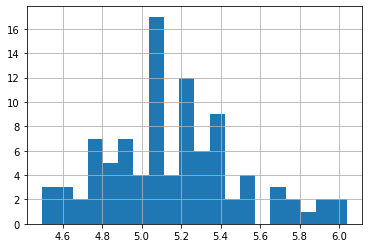

In [46]:
df_exp['prediction'].hist(bins=20)

In [59]:
%matplotlib inline

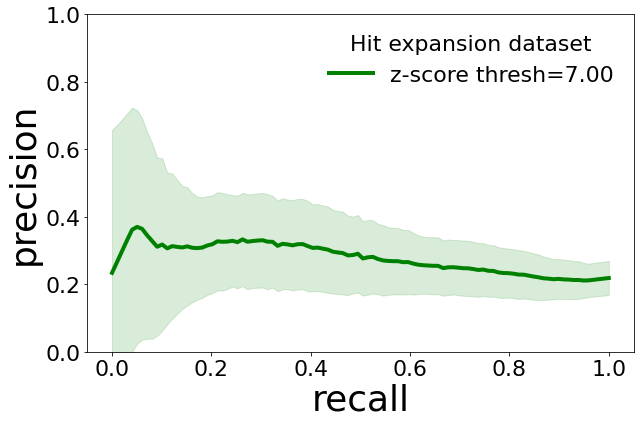

In [60]:
import matplotlib.pyplot as plt

thresh = 7
nbootstrap = 500
samplesize = 100
x = np.linspace(0,1,100)

ps = []
for i in range(nbootstrap):
    df_sample = df_exp.sample(n=samplesize,replace=True)
    yr = df_sample['z-score']> thresh
    p, r, _ = precision_recall_curve(yr, df_sample['prediction'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15
fig, ax = plt.subplots()
fig.set_size_inches(9,6)

#ax.plot(x,pavg,label='AUC={:.5f}, z-score thresh={}'.format(auc,thresh),color='g',lw=4)
ax.plot(x,pavg,label='z-score thresh={:.2f}'.format(thresh),color='g',lw=4)
ax.fill_between(x, pavg - perr, pavg + perr, color='g', alpha=alpha_err)

ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=36)
ax.set_ylabel('precision',fontsize=36)
ax.set_ylim(0,1)
ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,title='Hit expansion dataset',fontsize=22)
l.get_title().set_fontsize(22)

fig.tight_layout()
fig.savefig('affinity_pred_hit_expansion.png',dpi=300)

**Primary screen**

In [154]:
df_primary = pd.read_csv('/home/xvg/primary_screen_combined.csv')
df_primary = df_primary[(df_primary['smiles'].notnull())]

In [155]:
class PrimaryScreenDataset(Dataset):
    def __init__(self, df, seq):
        self.df = df
        self.seq = seq
        
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        item = {'smiles': [row['smiles']], 'seq': [self.seq]}        
        item = encode(item)
        
        # get first (single) item
        item['input_ids'] = item['input_ids'][0]
        item['token_type_ids'] = item['token_type_ids'][0]
        item['attention_mask'] = item['attention_mask'][0]
                
        # drop the non-encoded input
        item.pop('smiles')
        item.pop('seq')
        return item

    def __len__(self):
        return len(self.df)

In [52]:
primary_screen_dataset = PrimaryScreenDataset(df=df_primary, seq=mpro_seq_5r84)

In [53]:
primary_screen_dataset[0]

{'input_ids': tensor([ 2, 10,  7,  ...,  0,  0,  0]),
 'token_type_ids': tensor([0, 0, 0,  ..., 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0])}

In [54]:
y=trainer.predict(primary_screen_dataset)

RDKit ERROR: [17:59:57] SMILES Parse Error: syntax error while parsing: CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O
RDKit ERROR: [17:59:57] SMILES Parse Error: Failed parsing SMILES 'CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O' for input: 'CCn1nc(C(=O)NN=Crc(nc3ccccn3c2=O)N2CCCCC2)c2ccccc2c1=O'


In [55]:
df_primary['prediction'] = scale(y.predictions)

<AxesSubplot:>

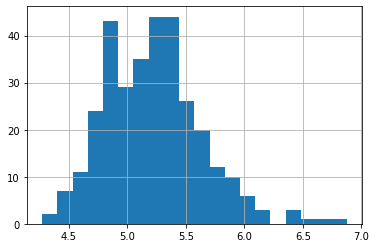

In [62]:
df_primary['prediction'].hist(bins=20)

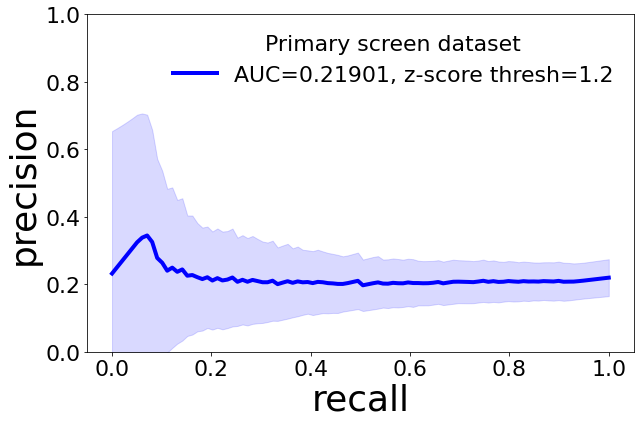

In [61]:
import matplotlib.pyplot as plt

thresh = 1.2
nbootstrap = 500
samplesize = 50
x = np.linspace(0,1,100)

ps = []
for i in range(nbootstrap):
    df_sample = df_primary.sample(n=samplesize,replace=True)
    yr = df_sample['z-score']> thresh
    p, r, _ = precision_recall_curve(yr, df_sample['prediction'])
    ps.append(np.interp(x,r[::-1],p[::-1]))
    
ps = np.vstack(ps)
pavg = np.mean(ps,axis=0)
perr = np.std(ps,axis=0)
auc = np.trapz(pavg[::-1],x)
alpha_err = 0.15
fig, ax = plt.subplots()
fig.set_size_inches(9,6)

ax.plot(x,pavg,label='AUC={:.5f}, z-score thresh={}'.format(auc,thresh),color='b',lw=4)
ax.fill_between(x, pavg - perr, pavg + perr, color='b', alpha=alpha_err)


ax.set_ylim(0,1)

ax.set_xlabel('recall',fontsize=36)
ax.set_ylabel('precision',fontsize=36)
ax.set_ylim(0,1)
ax.tick_params(labelsize=22)
l = ax.legend(frameon=False,title='Primary screen dataset',fontsize=22)
l.get_title().set_fontsize(22)

fig.tight_layout()
fig.savefig('affinity_pred_primary_screen.png',dpi=300)

**Sequence attributions**

In [156]:
df = pd.read_csv('data/affinity_with_pred.csv')

In [157]:
explainer = EnsembleExplainer(trainer.model,
                              seq_tokenizer=seq_tokenizer,
                              smiles_tokenizer=smiles_tokenizer,
                              internal_batch_size=1)

In [158]:
#df.sort_values(by='prediction',ascending=False).head(8)
df.sort_values(by='f_avg_IC50',ascending=True).head(8)

,Unnamed: 0,Unnamed: 0.1,SMILES,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,...,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series,frag_id,prediction
864,864,864,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1C...,JOH-MSK-46727e7b-1,JOH-MSK-46727e7b-1,NaN,NaN,0.025860,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,7.772982
420,420,420,C=CC(=O)N(C(=O)C1COc2ccc(Cl)cc21)c1cncc2ccccc12,MAT-POS-e69ad64a-2,MAT-POS-e69ad64a-2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,False,3-aminopyridine-like,NaN,6.240713
1072,1072,1072,O=C(Oc1cncc(Cl)c1)c1cccc2[nH]ccc12,ALP-POS-c59291d4-5,ALP-POS-c59291d4-5,NaN,NaN,0.055726,NaN,NaN,...,NaN,NaN,NaN,99.0,NaN,False,False,activated-ester,x10812,5.551895
216,216,216,C#CCCCC(=O)N[C@H](C(=O)N[C@H](CC(C)C)C(=O)NN(C...,STE-KUL-d79e3d6a-2,STE-KUL-d79e3d6a-2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,Ugi,NaN,4.804435
217,217,217,C#CCCCC(=O)N[C@H](C(=O)N[C@H](CC(C)C)C(=O)NN(C...,STE-KUL-d79e3d6a-3,STE-KUL-d79e3d6a-3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,True,Ugi,NaN,4.898615
400,400,400,O=C(Nc1cncc2ccccc12)[C@@H]1CCNc2cc(Cl)c(Cl)cc21,MAT-POS-f9802937-8,MAT-POS-f9802937-8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,6.733609
74,74,74,CC1CCN(S(=O)(=O)N2Cc3ccc(Cl)cc3C(C(=O)Nc3cncc4...,MAT-POS-4223bc15-11,MAT-POS-4223bc15-11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,5.441101
75,75,75,N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C(C(=O)Nc3cncc4...,MAT-POS-4223bc15-12,MAT-POS-4223bc15-12,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN,6.262978


In [159]:
idx = 864

In [160]:
df.iloc[idx].prediction, 6-np.log(df.iloc[idx].f_avg_IC50)/np.log(10)

(7.7729816, 7.5220050484634715)

In [161]:
loader = torch.utils.data.DataLoader([postera_dataset[idx]],batch_size=1)

In [162]:
device = torch.device("cuda:0")

In [32]:
all_seq_att = []
all_smiles_att = []
for item in tqdm.notebook.tqdm(loader):
    input_ids = item['input_ids'].to(device)
    attention_mask = item['attention_mask'].to(device)
    seq_attributions, smiles_attributions = explainer(input_ids,attention_mask)
    all_seq_att.append(seq_attributions)
    all_smiles_att.append(smiles_attributions)

/home/xvg/miniconda3/envs/affinity/lib/python3.8/site-packages/captum/attr/_core/layer/layer_integrated_gradients.py:103: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(


In [33]:
avg_seq = np.mean(all_seq_att,axis=0)
avg_smiles = np.mean(all_smiles_att,axis=0)

In [34]:
np.count_nonzero(seq_attributions)

307

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
np.argmax(avg_seq)

38

In [37]:
np.argsort(avg_seq)[::-1][:15]

array([ 38,   3,  60,  61,   2,  31, 112,  55,  32,  46, 176,   7, 187,
        50,  44])

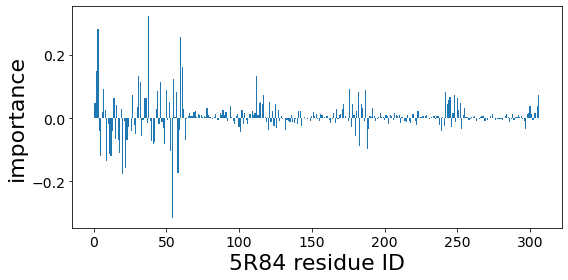

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
x = np.arange(1,len(mpro_seq_5r84)+1)
#ax.axvline(41,color='r')
#ax.axvline(145,color='r')
ax.bar(x,avg_seq[1:len(mpro_seq_5r84)+1])
ax.tick_params(labelsize=14)
ax.set_xlabel('5R84 residue ID',fontsize=22)
ax.set_ylabel('importance',fontsize=22)
fig.tight_layout()

In [50]:
df[df.canonical_CID=='MAT-POS-b3e365b9-1']

,Unnamed: 0,Unnamed: 0.1,SMILES,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,...,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series,frag_id,prediction
854,854,854,O=C(Nc1cncc2ccccc12)[C@@H]1CCOc2ccc(Cl)cc21,MAT-POS-b3e365b9-1,MAT-POS-b3e365b9-1,NaN,NaN,0.245516,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,x11612,5.723264


In [51]:
np.count_nonzero(postera_dataset[854]['input_ids'][max_seq_length:].cpu().numpy())

19

In [90]:
mol3d = Chem.MolFromPDBFile('data/Mpro-x11612_0A.pdb')
AllChem.Compute2DCoords(mol)

0

In [91]:
smi = df[df.canonical_CID=='MAT-POS-b3e365b9-1']['SMILES'].values[0]

In [92]:
mol2d = Chem.MolFromSmiles(smi)
AllChem.Compute2DCoords(mol2d)

0

In [93]:
from rdkit.Chem import AllChem

In [105]:
AllChem.GenerateDepictionMatching3DStructure(mol2d,mol3d)

In [123]:
[smiles_tokenizer.vocab[t] for t in postera_dataset[854]['input_ids'].cpu().numpy()]

KeyError: 2

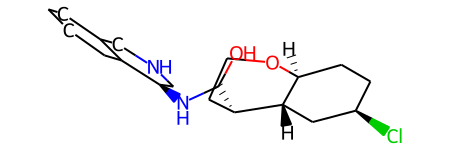

In [112]:
mol3d

In [107]:
mol2d.GetSubstructMatch(mol3d)

()

In [44]:
import py3Dmol

def MolTo3DView(pdb, residue_bfactors=None, size=(800, 600), style="stick",
                surface=False, opacity=1, expand_sidechains=[], ligand_pdb=None):
    assert style in ('line', 'stick', 'sphere', 'carton')

    def update_bfactor(line):
        if line.startswith('ATOM'):
            resid = int(line[23:26].strip())-1
            bfactor = residue_bfactors[resid] if residue_bfactors is not None else 0
            line = "%s%6.2F%s" % (line[:60],bfactor,line[66:])
        return line
    def get_resid(line):
        resid = None
        if line.startswith('ATOM'):
            resid = int(line[23:26].strip())
        return resid


    with open(pdb) as ifile:
        system = "".join([update_bfactor(x) for x in ifile if x.startswith('ATOM')
                          and get_resid(x) not in expand_sidechains and (' A ' in x or ' B ' in x)])

    vmin, vmax = np.min(residue_bfactors), np.max(residue_bfactors)

    v = py3Dmol.view(width=size[0], height=size[1])    

    cs = {'prop':'b','gradient':'rwb','min':vmin,'max': vmax}
    if len(expand_sidechains) > 0:
        with open(pdb) as ifile:
            sidechains = "".join([update_bfactor(x).replace(' A ', ' C ').replace(' B ',' D ')
                                  for x in ifile if get_resid(x) in expand_sidechains and (' A ' in x or ' B ' in x)])
        m_sidechains = v.addModel(sidechains,'pdb')
        #v.setStyle({'chain': 'C'}, {'stick': {'radius': 0.35, 'colorscheme': cs}})
        #v.setStyle({'chain': 'D'}, {'stick': {'radius': 0.35, 'colorscheme': cs}})
        v.setStyle({'chain': 'C'}, {'stick': {'radius': 0.35, 'color': 'green'}})
        v.setStyle({'chain': 'D'}, {'stick': {'radius': 0.35, 'color': 'green'}})
        
    v.addModel(system,'pdb')
    v.setStyle({'chain': 'A'},{'cartoon': {'color':'white', 'colorscheme':cs}})
    v.setStyle({'chain': 'B'},{'cartoon': {'color':'white', 'colorscheme':cs}})

    if ligand_pdb is not None:
        def update_bfactor(line):
            resid = int(line[23:26].strip())-1
            bfactor = residue_bfactors[resid] if residue_bfactors is not None else 0
            line = "%s%6.2F%s" % (line[:60],bfactor,line[66:])
            return line
        with open(ligand_pdb) as ifile:
            ligand = "".join([x for x in ifile if x.startswith('HETATM')])
        
        v.addModel(ligand,'pdb')
        v.setStyle({'resn': 'LIG','byres': True},{'stick': {}})
 
    if surface:
        v.addSurface(py3Dmol.SAS, {'opacity': opacity,'colorscheme': cs})
        
    v.setHoverable({},True,'''function(atom,viewer,event,container) {
               if(!atom.label) {
                atom.label = viewer.addLabel(atom.resn+" "+atom.resi+":"+atom.atom,{position: atom, backgroundColor: 'mintcream', fontColor:'black'});
               }}''',
           '''function(atom,viewer) { 
               if(atom.label) {
                viewer.removeLabel(atom.label);
                delete atom.label;
               }
            }''')
    v.zoomTo()
    return v

In [45]:
colors=avg_seq[1:len(mpro_seq_5r84)+1]*100
#colors -= np.min(colors)

In [46]:
MolTo3DView('data/Mpro-x11612_0A_apo-desolv.pdb', residue_bfactors=colors, surface=False,opacity=0.9,
           expand_sidechains=[41,145],
           ligand_pdb = 'data/Mpro-x11612_0A.pdb')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [88]:
MolTo3DView('data/6lu7_dimer.pdb', residue_bfactors=colors, surface=False,opacity=0.9,
           expand_sidechains=[41,145])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol